In [2]:
import chess
import chess.polyglot
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter


pgn = open("lichess_db_standard_rated_2014-12.pgn")

for i in range(3):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    print(f"partie {i + 1}:\n")
    print(game)
    print("\n" + "-" * 50 + "\n")

partie 1:

[Event "Rated Bullet game"]
[Site "https://lichess.org/kkoeqcF0"]
[Date "????.??.??"]
[Round "?"]
[White "carlsen89"]
[Black "goltrpoat"]
[Result "0-1"]
[UTCDate "2014.11.30"]
[UTCTime "23:00:03"]
[WhiteElo "2070"]
[BlackElo "1918"]
[WhiteRatingDiff "-15"]
[BlackRatingDiff "+16"]
[ECO "B18"]
[Opening "Caro-Kann Defense: Classical Variation"]
[TimeControl "60+0"]
[Termination "Normal"]

1. e4 c6 2. d4 d5 3. Nd2 dxe4 4. Nxe4 Bf5 5. Ng3 Bg6 6. Nf3 Nd7 7. Bd3 Ngf6 8. c4 e6 9. Qc2 Be7 10. Bg5 O-O 11. O-O b5 12. cxb5 cxb5 13. Bxb5 Bxc2 0-1

--------------------------------------------------

partie 2:

[Event "Rated Blitz tournament https://lichess.org/tournament/X5BO0Amj"]
[Site "https://lichess.org/IqsDiXIt"]
[Date "????.??.??"]
[Round "?"]
[White "nunutsu"]
[Black "sergeblanc"]
[Result "0-1"]
[UTCDate "2014.11.30"]
[UTCTime "23:00:40"]
[WhiteElo "1406"]
[BlackElo "1567"]
[WhiteRatingDiff "-6"]
[BlackRatingDiff "+7"]
[ECO "A40"]
[Opening "Horwitz Defense"]
[TimeControl "300+0"]


In [4]:
with open("lichess_db_standard_rated_2014-12.pgn") as f:
    nb_parties = sum(1 for line in f if line.startswith("[Event "))
print(f"Nombre total de parties : {nb_parties}")


Nombre total de parties : 1350176


Calculer l'entropie sur distib 
Gaussienne 
Plus proche voisin (Obama)

In [ ]:
#On va essayer de génerer 4000 échantillons sur la base de données pour appliquer ensuite le test de Shapiro
import random 
reservoir_sampling = []
k = 4000
i = 0

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    diff_str = game.headers.get("WhiteRatingDiff")
    elo_str = game.headers.get("WhiteElo")

    if diff_str is None or elo_str is None:
        continue

    diff = int(diff_str)
    elo = int(elo_str)
    
    if not (-10 < diff < 10):
        continue
    i += 1
    if(len(reservoir_sampling)) < k:
        reservoir_sampling.append(elo)
    else:
        j = random.randint(0, i- 1)
        if j < k :
            reservoir_sampling[j] = elo

x = scipy.stats.shapiro(reservoir_sampling)
print(x.pvalue)


KeyboardInterrupt: 

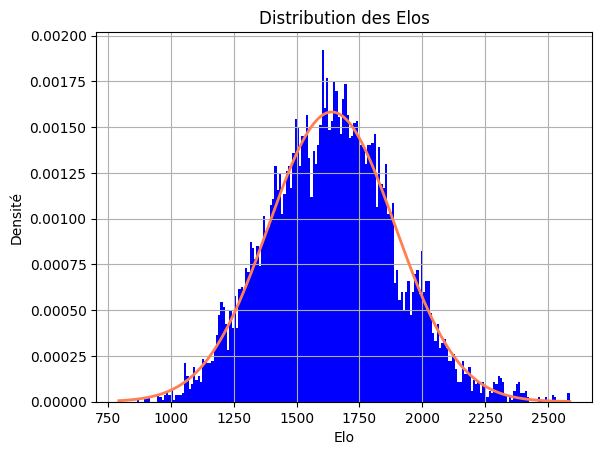

In [5]:
array = []


for _ in range(20000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    diff = int(game.headers.get("WhiteRatingDiff", 999))
    if( -10 < diff < 10):
        array.append(int(game.headers.get("WhiteElo")))

mean_array = np.mean(array)
std_array = np.std(array)
array.sort()

x = np.linspace(min(array), max(array), 1000)
y = scipy.stats.norm.pdf(x, mean_array, std_array)

plt.hist(array, bins=200, density=True, color='blue', label="Distribution de la base")
plt.plot(x, y, color='coral', linewidth=2, label="Gaussienne théorique")

plt.title('Distribution des Elos', fontsize=12)
plt.xlabel('Elo')
plt.ylabel('Densité')
plt.grid()
plt.show()

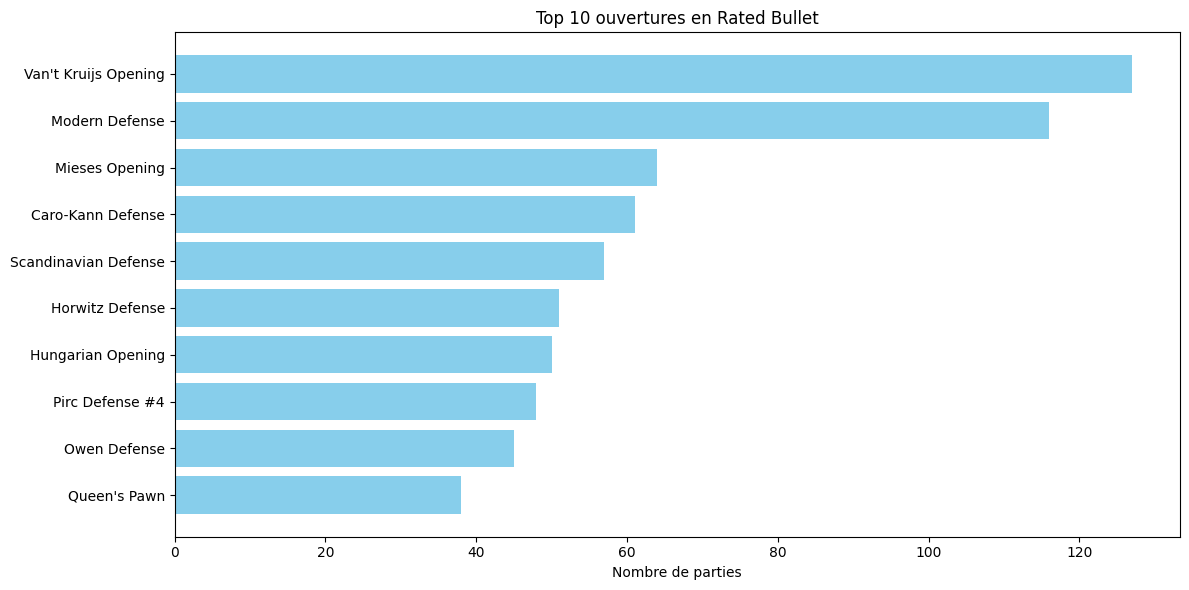

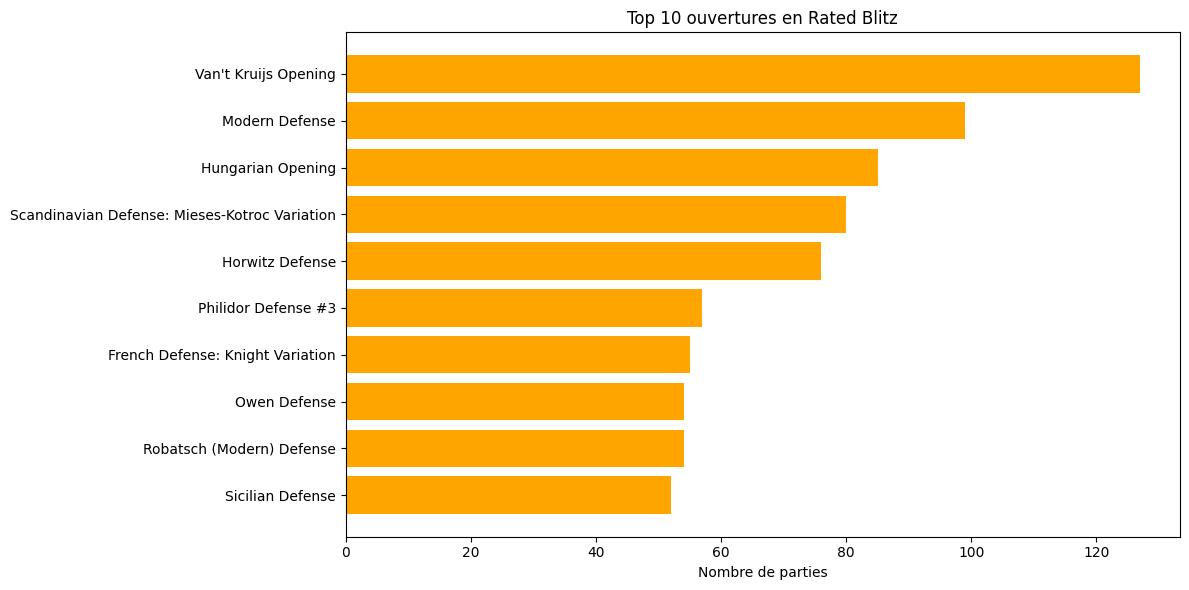

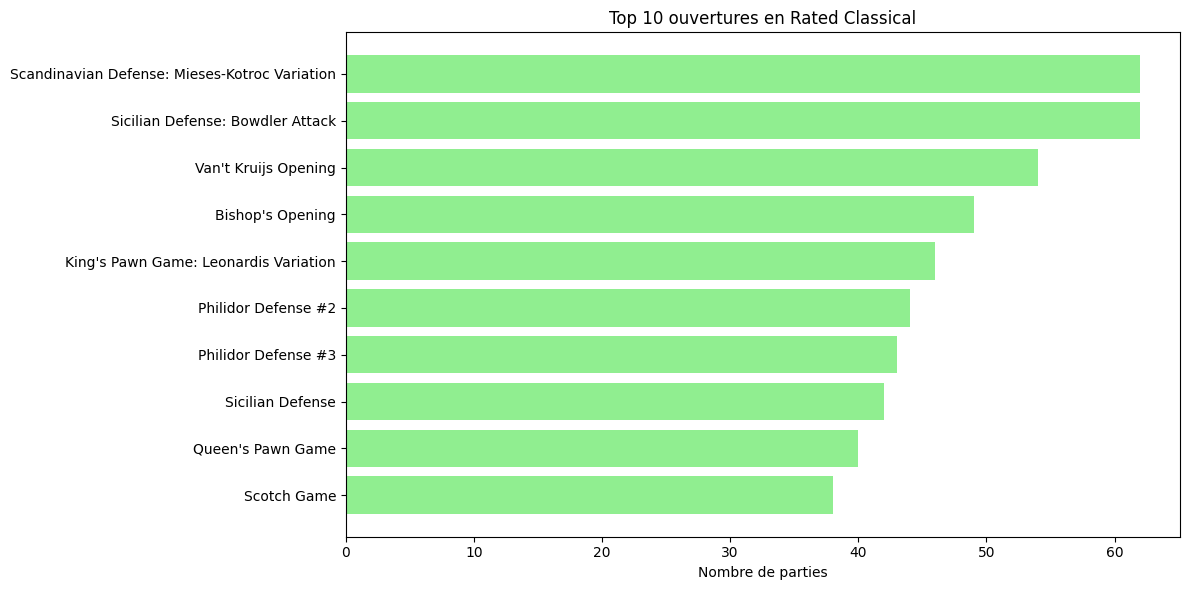

In [8]:
bullet_stats = Counter()
blitz_stats = Counter()
classical_stats = Counter()
blitz_stats_ECO = Counter()

for _ in range(10000):
    game = chess.pgn.read_game(pgn)
    if (game.headers.get("Opening") == "?"):
        continue
    if game is None:
        break

    event = game.headers.get("Event", "")
    opening = game.headers.get("Opening", "Unknown")



    if "Rated Bullet" in event:
        bullet_stats[opening] += 1
    elif "Rated Blitz" in event:
        blitz_stats[opening] += 1
    elif "Rated Classical" in event:
        classical_stats[opening] += 1

def plot_openings(stats, title, color):
    top_openings = stats.most_common(10)
    openings = [item[0] for item in top_openings]
    counts = [item[1] for item in top_openings]

    plt.figure(figsize=(12, 6))
    plt.barh(openings[::-1], counts[::-1], color=color)
    plt.xlabel("Nombre de parties")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_openings(bullet_stats, "Top 10 ouvertures en Rated Bullet", "skyblue")
plot_openings(blitz_stats, "Top 10 ouvertures en Rated Blitz", "orange")
plot_openings(classical_stats, "Top 10 ouvertures en Rated Classical", "lightgreen")

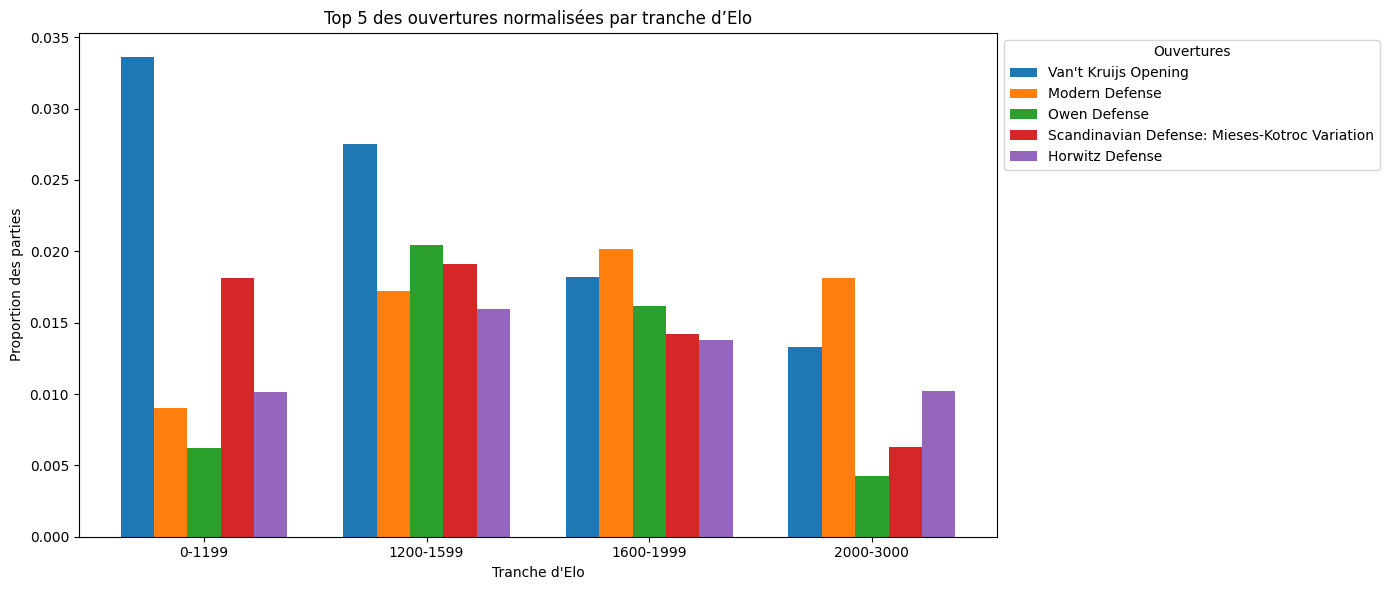

In [9]:
elo_ranges = [(0, 1199), (1200, 1599), (1600, 1999), (2000, 3000)]
elo_labels = [f"{low}-{high}" for low, high in elo_ranges]
elo_opening_stats = {label: Counter() for label in elo_labels}

for _ in range(200000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    average_elo = (white_elo + black_elo) // 2
    opening = game.headers.get("Opening", "Unknown")

    for (low, high), label in zip(elo_ranges, elo_labels):
        if low <= average_elo <= high:
            elo_opening_stats[label][opening] += 1
            break

total_opening_counts = sum(elo_opening_stats.values(), Counter())
top_openings = [opening for opening, _ in total_opening_counts.most_common(5)]

bar_width = 0.15
x = np.arange(len(elo_labels))

plt.figure(figsize=(14, 6))

for i, opening in enumerate(top_openings):
    counts = []
    for label in elo_labels:
        total = sum(elo_opening_stats[label].values())
        if total > 0:
            count = elo_opening_stats[label][opening] / total
        else:
            count = 0
        counts.append(count)

    plt.bar(x + i * bar_width, counts, width=bar_width, label=opening)

plt.xlabel("Tranche d'Elo")
plt.ylabel("Proportion des parties")
plt.title("Top 5 des ouvertures normalisées par tranche d’Elo")
plt.xticks(x + bar_width * 2, elo_labels)
plt.legend(title="Ouvertures", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


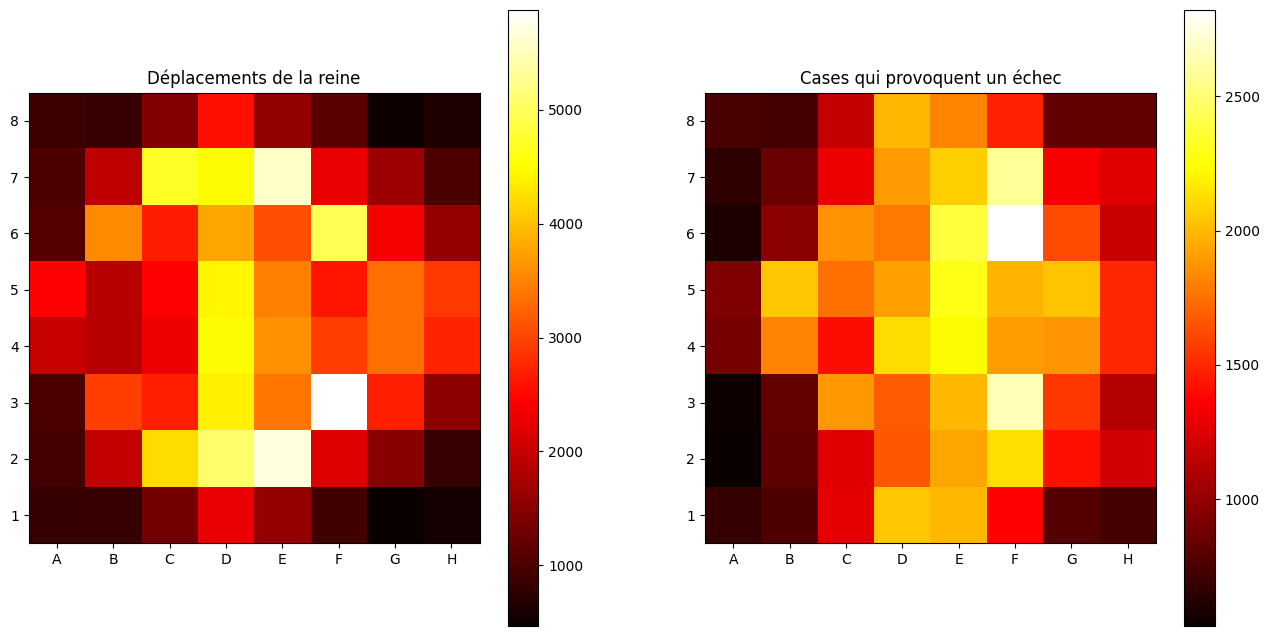

In [2]:
#ON essaie de mesurer la fréquence des coups de Dame et les pièces qui mettent en échecs

queen_moves = Counter()
check_moves = Counter()

for _ in range(20000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    board = game.board()
    for move in game.mainline_moves():
        piece = board.piece_at(move.from_square)
        if piece and piece.piece_type == chess.QUEEN:
            square = move.to_square
            queen_moves[square] += 1
        
        board.push(move)

        if board.is_check():
            check_moves[move.to_square] += 1


board_chess = np.zeros((8,8))
board_chess1 = np.zeros((8,8))


for square, count in queen_moves.items():
    row = chess.square_rank(square)
    column = chess.square_file(square)
    board_chess[7-row, column] = count #Inverse l'axe des rangées pour avoir un échequier avec le blanc en bas

board_chess1 = np.zeros((8,8))

for square, count in check_moves.items():
    row = chess.square_rank(square)
    column = chess.square_file(square)
    board_chess1[7 - row, column] = count #Inverse l'axe des rangées pour avoir un échequier avec le blanc en bas


fig, axs = plt.subplots(1, 2, figsize=(16,8))

im0 = axs[0].imshow(board_chess, cmap="hot", interpolation="nearest")
axs[0].set_title("Déplacements de la reine")
fig.colorbar(im0, ax=axs[0])
axs[0].set_xticks(np.arange(8))
axs[0].set_xticklabels(['A','B','C','D','E','F','G','H'])
axs[0].set_yticks(np.arange(8))
axs[0].set_yticklabels(list(reversed(range(1,9))))

im1 = axs[1].imshow(board_chess1, cmap="hot", interpolation="nearest")
axs[1].set_title("Cases qui provoquent un échec")
fig.colorbar(im1, ax=axs[1])
axs[1].set_xticks(np.arange(8))
axs[1].set_xticklabels(['A','B','C','D','E','F','G','H'])
axs[1].set_yticks(np.arange(8))
axs[1].set_yticklabels(list(reversed(range(1,9))))
plt.show()


On remarque de la case de Qd8 est plus colorée que Qd1, cela vient probablement d'une variante qui est régulièrement joué sur la défense Scandinave ! 

In [17]:
# On va essayer de déterminer le coup le plus rare joué dans la database 
piece_mouvement_white = Counter()
piece_mouvement_black = Counter()

for _ in range(200000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    board = game.board()
    for move in game.mainline_moves():
        move_san = board.san(move)
        if board.turn == chess.WHITE :
            piece_mouvement_white[move_san] += 1        
        else:
            piece_mouvement_black[move_san] += 1        
        board.push(move)
    
total_moves_white = sum(piece_mouvement_white.values())
total_moves_black = sum(piece_mouvement_black.values())

most_common_move_white, most_common_count_white = piece_mouvement_white.most_common(1)[0]
most_common_move_black, most_common_count_black = piece_mouvement_black.most_common(1)[0]


rarest_move_white, rarest_count_white = piece_mouvement_white.most_common()[-1]
rarest_move_black, rarest_count_black = piece_mouvement_black.most_common()[-1]

pourcentage_max_white = (most_common_count_white / total_moves_white) * 100
pourcentage_max_black = (most_common_count_black / total_moves_black) * 100

pourcentage_min_white = (rarest_count_white / total_moves_white) * 100
pourcentage_min_black = (rarest_count_black / total_moves_black) * 100




print("=== Statistiques sur les coups analysés ===")
print(f"Nombre total de coups des Blancs : {total_moves_white}")
print(f"Nombre total de coups des Noirs  : {total_moves_black}\n")

print(f"Coup le plus fréquent chez les Blancs : {most_common_move_white} (soit {pourcentage_max_white:5f}%)")
print(f"Coup le plus fréquent chez les Noirs  : {most_common_move_black} (soit {pourcentage_max_black:5f}%)\n")


print(f"Coup le moins fréquent chez les Blancs : {rarest_move_white} (soit {pourcentage_min_white:5f}%)")
print(f"Coup le moins fréquent chez les Noirs  : {rarest_move_black} (soit {pourcentage_min_black:5f}%)\n")




=== Statistiques sur les coups analysés ===
Nombre total de coups des Blancs : 6586118
Nombre total de coups des Noirs  : 6483351

Coup le plus fréquent chez les Blancs : Nf3 (soit 2.839837%)
Coup le plus fréquent chez les Noirs  : Nf6 (soit 2.584127%)

Coup le moins fréquent chez les Blancs : Rbd2+ (soit 0.000015%)
Coup le moins fréquent chez les Noirs  : R1xh3 (soit 0.000015%)



In [ ]:
player_data = {}
pgn = open("lichess_db_standard_rated_2014-12.pgn")

for _ in range(200000):
    game = chess.pgn.read_game(pgn)
    if game is None:
        break

    event = game.headers.get("Event")
    if not event or not event.startswith("Rated"):
        continue

    parts = event.split()
    if len(parts) < 3:
        continue
    game_type = parts[1]

    if game_type not in ["Bullet", "Blitz", "Rapid", "Classical"]:
        continue

    for color in ["White", "Black"]:
        player = game.headers.get(color)
        rating_str = game.headers.get(f"{color}Elo")

        if not player or not rating_str:
            continue

        rating = int(rating_str)

        if player not in player_data:
            player_data[player] = {
                "Bullet": [], "Blitz": [], "Rapid": [], "Classical": []
            }

        player_data[player][game_type].append(rating)


# Construire un DataFrame des joueurs ayant ≥ 3 parties 
records = []
for player, ratings_by_type in player_data.items():
    record = {"player": player}
    count_types = 0
    for game_type in ["Bullet", "Blitz", "Rapid", "Classical"]:
        ratings = ratings_by_type[game_type]
        if len(ratings) >= 3:
            record[game_type] = sum(ratings) / len(ratings)
            count_types += 1
    if count_types >= 2:
        records.append(record)

df = pd.DataFrame(records)
print(df.head())

             player       Bullet        Blitz    Classical
0           PILOTVE  1574.000000  1659.000000          NaN
1      sanmiguelino          NaN  1940.666667  1949.333333
2  jarek_z_warszawy          NaN  1075.250000  1084.000000
3    helmutLipfert6  1632.750000  1652.000000          NaN
4            Triman  1345.333333  1392.333333          NaN


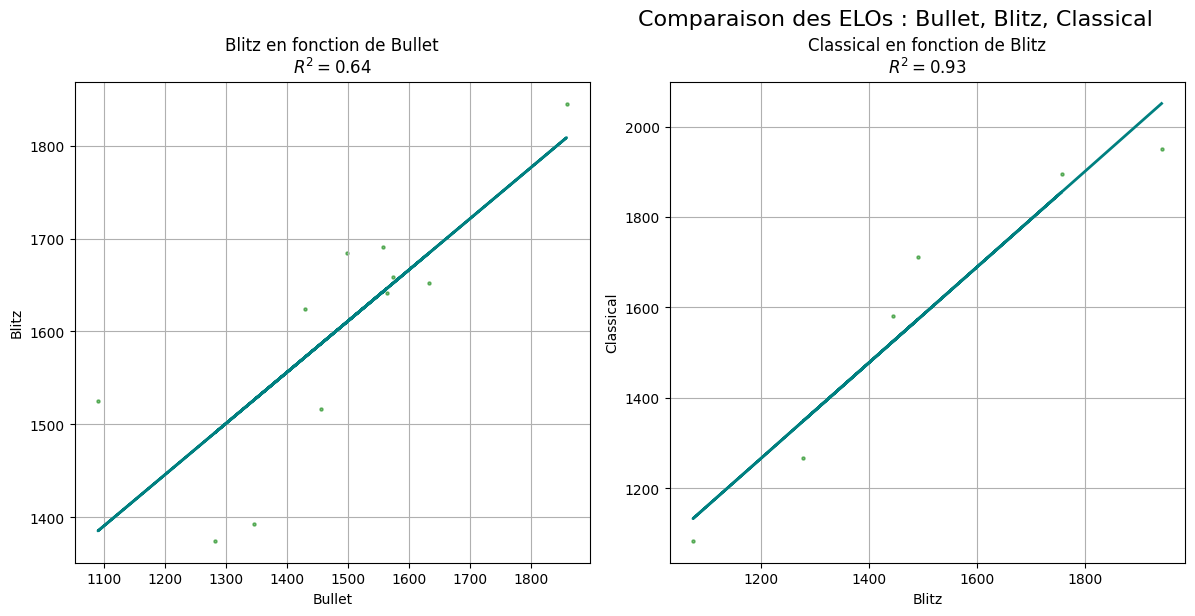

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Choix des types à comparer
types = ["Bullet", "Blitz", "Classical"]

# Créer une figure pour 3 graphiques
plt.figure(figsize=(18, 6))  # Largeur plus grande pour plus d'espace entre les graphiques

# Liste des comparaisons à faire (x_type, y_type)
comparisons = [
    ("Bullet", "Blitz"),
    ("Blitz", "Classical"),
    ("Bullet", "Classical")
]

# Pour chaque comparaison, générer un graphique
for i, (x_type, y_type) in enumerate(comparisons):
    # Filtrer les données pour les colonnes x_type et y_type
    df_plot = df.dropna(subset=[x_type, y_type])
    if df_plot.empty:
        continue

    X = df_plot[x_type].values.reshape(-1, 1)  # Valeurs de x
    y = df_plot[y_type].values  # Valeurs de y

    # Appliquer une régression linéaire
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)  # Prédictions de la régression
    r2 = r2_score(y, y_pred)  # Calcul du coefficient R²

    # Création du graphique
    plt.subplot(1, 3, i + 1)  # 1 ligne, 3 colonnes, graphique i+1
    plt.scatter(X, y, alpha=0.5, s=5, color='green')  # Points de données
    plt.plot(X, y_pred, color='teal', linewidth=2)  # Ligne de régression
    plt.xlabel(x_type)  # Label de l'axe X
    plt.ylabel(y_type)  # Label de l'axe Y
    plt.title(f"{y_type} en fonction de {x_type}\n$R^2 = {r2:.2f}$")  # Titre avec R²
    plt.grid(True)

# Ajuster l'agencement des graphiques et ajouter un titre global
plt.tight_layout()
plt.suptitle("Comparaison des ELOs : Bullet, Blitz, Classical", fontsize=16, y=1.02)
plt.show()
